Let us compute the tangents lines to a circle
via a witness set intersection.
With matplotlib a plot is made of the tangent lines.

# Tangent Lines via Witness Set Intersection

In [1]:
from math import cos, sin, pi
from random import uniform
import matplotlib.pyplot as plt
from phcpy.solver import solve
from phcpy.solutions import make_solution, coordinates, strsol2dict
from phcpy.sets import double_embed
from phcpy.diagonal import double_diagonal_solve

PHCv2.4.88 released 2023-12-26 works!


## 1. A Witness Set of the Circle

Consider the following system of polynomial equations:

$$
   \left\{
      \begin{array}{rcl}
         (x-a)^2 + (y-b)^2 & = & r^2 \\
                         y & = & s x
      \end{array}
   \right.
$$

which represents a circle centered at $(a, b)$ with radius $r$, intersected by a line with slope $s$.

The code below plots an example, a circle centered at $(3, 2)$, with radius $1$, intersected with the line $y= x$.

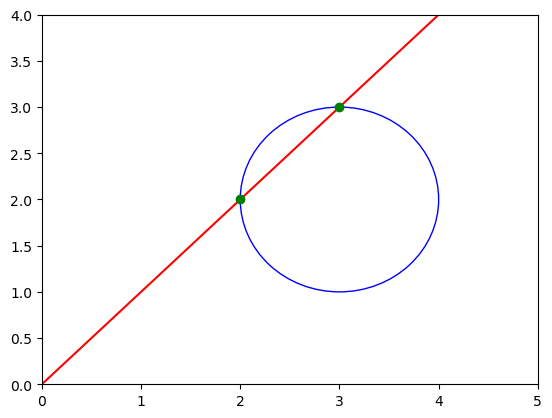

In [2]:
fig1 = plt.figure()
axs = fig1.gca()
center = (3, 2)
radius = 1
circle = plt.Circle(center, radius, edgecolor='blue', facecolor='none')
axs.add_artist(circle)
plt.plot([0, 4], [0, 4], 'r') 
plt.plot([2, 3], [2, 3], 'go')
plt.axis([0, 5, 0, 4])
fig1.canvas.draw()
plt.savefig('touchcirclefig1')

The system above has two equations in three variables $(x, y, s)$ and thus defines a curve.  What is the degree of this curve?

In [3]:
def polynomials(a, b, r):
    """
    Returns string representations of two polynomials:
    1) a circle with radius r centered at (a, b);
    2) a line through the origin with slope s.
    """
    crc = '(x - %.15e)^2 + (y - %.15e)^2 - %.15e;' % (a, b, r**2)
    lin = 'y - s*x;'
    return [crc, lin]

In [4]:
def make_witness_set(pols, verbose=True):
    """
    We have two equations in three variables in pols
    and therefore we expect a one dimensional set.
    """
    embpols = double_embed(3, 1, pols)
    if verbose:
        print('the embedded system :')
        for pol in embpols:
            print(pol)
    embsols = solve(embpols)
    if verbose:
        print('the witness points :')
        for sol in embsols:
            print(sol)
    return (embpols, embsols)

In [5]:
def special_solutions(pols, slope):
    """
    Given in pols the polynomials for the line intersecting a circle
    for a general slope s, solves the problem for a special numerical
    value for s, given in the slope.
    The value of the slope is added as last coordinate to each solution.
    """
    special = []
    for pol in pols:
        rpl = pol.replace('s', '(' + str(slope) + ')')
        special.append(rpl)
    sols = solve(special)
    result = []
    for sol in sols:
        (vars, vals) = coordinates(sol)
        vars.append('s')
        vals.append(slope)
        extsol = make_solution(vars, vals)
        result.append(extsol)
    return result

Consider a circle with radius $1$, centered at $(3, 2)$, intersected with the line $y = x$.

In [6]:
def circle_line_set():
    """
    Generates the system and its witness set.
    Returns the witness set for a fixed circle 
    intersect with a one parameter family of lines 
    as a tuple of polynomials and solutions
    """
    syst = polynomials(3, 2, 1)
    for pol in syst:
        print(pol)
    spsols = special_solutions(syst, 1)
    for (idx, sol) in enumerate(spsols):
        print('Solution', idx+1, ':')
        print(sol)
    (embsyst, embsols) = make_witness_set(syst, False)
    print('the polynomials in the witness set:')
    for pol in embsyst:
        print(pol)
    print('the solutions :')
    for (idx, sol) in enumerate(embsols):
        print('Solution', idx+1, ':')
        print(sol)
    print('degree of the set :', len(embsols))
    return (embsyst, embsols)

In [7]:
(witpols, witsols) = circle_line_set()

(x - 3.000000000000000e+00)^2 + (y - 2.000000000000000e+00)^2 - 1.000000000000000e+00;
y - s*x;
Solution 1 :
t : 0.000000000000000E+00 0.000000000000000E+00
m : 1
the solution for t :
 x : 3.000000000000000E+00  0.000000000000000E+00
 y : 3.000000000000000E+00  0.000000000000000E+00
 s : 1.000000000000000E+00  0.0
== err : 0.000E+00 = rco : 1.000E+00 = res : 0.000E+00 =
Solution 2 :
t : 0.000000000000000E+00 0.000000000000000E+00
m : 1
the solution for t :
 x : 2.000000000000000E+00  0.000000000000000E+00
 y : 2.000000000000000E+00  0.000000000000000E+00
 s : 1.000000000000000E+00  0.0
== err : 0.000E+00 = rco : 1.000E+00 = res : 0.000E+00 =
the polynomials in the witness set:
 + x^2 + y^2 - 6*x - 4*y + (-6.05036692680377E-01 + 7.96197588862458E-01*i)*zz1 + 12;
 - x*s + y + (9.36812659577866E-01-3.49831446349018E-01*i)*zz1;
zz1;
 + (-9.78259528135350E-01 + 2.07384415066325E-01*i)*x + (-2.57730439432429E-01-9.66216860021583E-01*i)*y + (9.85142412110320E-01-1.71739418484693E-01*i)*s + (-

Thus, the degree of the algebraic curve defined by the system equals four.

## 2. Intersecting with the Jacobian

For any random slope $s$, the line $y = s x$ will intersect the circle in exactly two (complex) points, as solutions of the polynomial system.  A tangent line to the circle intersects the circle in one double solution, that is: a solution that has to be counted twice.  We look for values of the slope for which the intersection points are singular. Singular points satisfy the original equations and the equations defined by all partial derivatives of the system, called the Jacobian.

### 2.1 A Witness Set for the Jacobian

Let $f_1$ and $f_2$ denote the two polynomials in $(x, y, s)$, then the Jacobian is

$$
   J =
   \left[
      \begin{array}{ccc}
         \frac{\partial f_1}{\partial x}
         & \frac{\partial f_1}{\partial y}
         & \frac{\partial f_1}{\partial s} \\
         \frac{\partial f_2}{\partial x}
         & \frac{\partial f_2}{\partial y}
         & \frac{\partial f_2}{\partial s}
      \end{array}
   \right]
$$

which for the polynomials in our problem becomes

$$
    J =
    \left[
       \begin{array}{ccc}
          2 (x - a) & 2(y-b) & 0 \\
          -s & 1 & -x
       \end{array}
    \right]
$$

where the $-$ on the second row appears from the equation $-sx + y = 0$.

As we look for a singular solution, the rank of the Jacobian $J$ must be one, not two.  It suffices here to consider the first 2-by-2 minor and requiring that the first two columns are linearly dependent can be expressed by

$$
   \left\{
      \begin{array}{rlcrlcl}
         2(x-a) & L_1 & + & 2(y-b) & L_2 & = & 0 \\
             -s & L_1 & + &        & L_2 & = & 0 \\
         c_0 + c_1 & L_1 & + & c_2 & L_2 & = & 0
      \end{array}
   \right.
$$

where $L_1$ and $L_2$ are two new variables and $c_0$, $c_1$, and $c_2$ are random constants.

In [8]:
def random_complex():
    """
    Returns a random complex number on the unit circle.
    """
    theta = uniform(0, 2*pi)
    return complex(cos(theta), sin(theta))

In [9]:
def random_hyperplane(vars):
    """
    Returns a linear equation in the variables
    in the list vars, with random complex coefficients.
    """
    cf0 = str(random_complex())
    tf0 = cf0.replace('j', '*i')
    result = tf0
    for var in vars:
        cff = str(random_complex())
        tcf = cff.replace('j', '*i')
        result = result + '+' + tcf + '*' + var
    return result + ';'

In [10]:
def jacobian(a, b):
    """
    Returns the equations which define the points
    where the Jacobian matrix is singular,
    as a random linear combination of the columns.
    Random complex coefficients are generated to
    scale the multiplier variables.
    """
    eq1 = '2*(x-%.15e)*L1 + 2*(y-%.15e)*L2;' % (a, b)
    eq2 = '-s*L1 + L2;'
    eq3 = random_hyperplane(['L1', 'L2'])
    return [eq1, eq2, eq3]

Then here is an example for center $(3, 2)$.

In [11]:
jacpols = jacobian(3, 2)
for pol in jacpols:
    print(pol)

2*(x-3.000000000000000e+00)*L1 + 2*(y-2.000000000000000e+00)*L2;
-s*L1 + L2;
(-0.8664696134203578+0.49922981583552856*i)+(-0.9348124909840702+0.3551416713090113*i)*L1+(-0.1559269198116066+0.9877685941950497*i)*L2;


Let us now make a witness set, using the auxiliary function below.

In [12]:
def witset(pols, verbose=True):
    """
    We have three equations in pols in five variables:
    x, y, s, L1, and L2.
    Therefore we expect a two dimensional set.
    """
    embpols = double_embed(5, 2, pols)
    if verbose:
        print('the embedded system :')
        for pol in embpols:
            print(pol)
    embsols = solve(embpols)
    if verbose:
        print('the witness points :')
        for sol in embsols:
            print(sol)
    return (embpols, embsols)

As we have three equations in five variables $(x, y, s, L_1, L_3)$, the solution set is two dimensional.  The construction of this witness set will compute the degree of this two dimensional solution set

In [13]:
def singular_locus_set():
    """
    Generates a witness set for the singular locus
    of the algebraic set of a fixed circle intersected
    with a one parameter family of lines.
    """
    syst = jacobian(3, 2)
    for pol in syst:
        print(pol)
    (embsyst, embsols) = witset(syst, False)
    print('the polynomials in the witness set :')
    for pol in embsyst:
        print(pol)
    print('the solutions :')
    for sol in embsols:
        print(sol)
    print('degree of the singular locus set :', len(embsols))
    return (embsyst, embsols)

In [14]:
witset2 = singular_locus_set()

2*(x-3.000000000000000e+00)*L1 + 2*(y-2.000000000000000e+00)*L2;
-s*L1 + L2;
(0.008780891137859756+0.9999614472322546*i)+(0.05948312760527637-0.998229311095549*i)*L1+(0.5424828774363553-0.8400668590584753*i)*L2;
the polynomials in the witness set :
 + 2*x*L1 + 2*y*L2 - 6*L1 - 4*L2 + (2.39511895530127E-01 + 9.70893429733442E-01*i)*zz1 + (2.26095721102785E-01-9.74105089248081E-01*i)*zz2;
 - L1*s + L2 + (-3.81524452270300E-01 + 9.24358746548031E-01*i)*zz1 + (4.96901462762026E-01-8.67806969495497E-01*i)*zz2;
 + (5.94831276052764E-02-9.98229311095549E-01*i)*L1 + (5.42482877436355E-01-8.40066859058475E-01*i)*L2 + (-1.41759839709119E-01 + 9.89901079828507E-01*i)*zz1 + (1.40952786827726E-01 + 9.90016318999590E-01*i)*zz2+(8.78089113785976E-03 + 9.99961447232255E-01*i);
zz1;
zz2;
 + (1.70882735987061E-01 + 3.09514281643960E-01*i)*x + (3.38347883960499E-01-1.02570509501770E-01*i)*L1 + (-1.60411222263324E-01-3.15068627083032E-01*i)*y + (-3.46278647811457E-01 + 7.13519310871769E-02*i)*L2 + (2.02545

The singular locus has degree three.

### 2.2 Extending with Slack Variables

The first witness set of the circle intersected with a line is a cubic curve.  In order to intersect this set with the singular locus, we have to add $L_1$ and $L_2$, increasing the dimension by two, using one as the values of the witness points for $L_1$ and $L_2$.

The function below adds to the solutions the values for the $L_1$ and $L_2$, and adds two additional slack variables `zz2` and `zz3`.

In [15]:
def extend_solutions(sols):
    """
    To each solution in sols, adds L1 and L2 with values 1,
    and zz2 and zz3 with values zero.
    """
    result = []
    for sol in sols:
        (vars, vals) = coordinates(sol)
        vars = vars + ['L1', 'L2', 'zz2', 'zz3']
        vals = vals + [1, 1, 0, 0]
        extsol = make_solution(vars, vals)
        result.append(extsol)
    return result

In [16]:
def extend(pols, sols, verbose=True):
    """
    Extends the witness set with two free variables
    L1 and L2, addition two linear equations,
    and two slack variables zz2 and zz3.
    """
    vars = ['zz2', 'zz3']
    eq1 = 'zz2;'
    eq2 = 'zz3;'
    eq3 = 'L1 - 1;'
    eq4 = 'L2 - 1;'
    extpols = pols[:-1] + [eq1, eq2, eq3, eq4, pols[-1]]
    extsols = extend_solutions(sols)
    if verbose:
        print('the extended polynomials :')
        for pol in extpols:
            print(pol)
        print('the extended solutions :')
        for sol in extsols:
            print(sol)
    return (extpols, extsols)

In [17]:
witset1 = extend(witpols, witsols)

the extended polynomials :
 + x^2 + y^2 - 6*x - 4*y + (-6.05036692680377E-01 + 7.96197588862458E-01*i)*zz1 + 12;
 - x*s + y + (9.36812659577866E-01-3.49831446349018E-01*i)*zz1;
zz1;
zz2;
zz3;
L1 - 1;
L2 - 1;
 + (-9.78259528135350E-01 + 2.07384415066325E-01*i)*x + (-2.57730439432429E-01-9.66216860021583E-01*i)*y + (9.85142412110320E-01-1.71739418484693E-01*i)*s + (-4.40186917636668E-01 + 8.97906162993400E-01*i)*zz1+(1.76012073314581E-01 + 9.84388007874691E-01*i);
the extended solutions :
t : 0.000000000000000E+00 0.000000000000000E+00
m : 1
the solution for t :
 x : 9.092874016572720E-01  6.212407384387740E+01
 y : -6.013211263069520E+01  -2.090442097434840E+00
 zz1 : 5.151647004273860E-31  7.468068137788200E-32
 s : -4.780654990710760E-02  9.672360329774140E-01
 L1 : 1.000000000000000E+00  0.0
 L2 : 1.000000000000000E+00  0.0
 zz2 : 0.000000000000000E+00  0.0
 zz3 : 0.000000000000000E+00  0.0
== err : 0.000E+00 = rco : 1.000E+00 = res : 0.000E+00 =
t : 0.000000000000000E+00 0.000000000

### 2.3 Intersecting Two Witness Sets

When intersecting two witness sets, the symbols must line up.  The function below ensures that the order of symbols is $(x, y, s, L1, L2)$ by adding a zero polynomial to a given polynomial.

In [18]:
def insert_symbols(pol):
    """
    To the string pol, adds the sequence of symbols.
    """
    q = pol.lstrip()
    if q[0] == '+' or q[0] == '-':
        smb = 'x - x + y - y + s + L1 - L1 + L2 - L2 - s '
    else:
        smb = 'x - x + y - y + s + L1 - L1 + L2 - L2 - s + '
    return smb + pol

In [19]:
def intersect(dim, w1d, w2d, ws1, ws2, verbose=True):
    """
    Applies the diagonal homotopy to intersect two witness sets
    w1 and w2 of dimensions w1d and w2d in a space of dimension dim.
    """
    w1eqs, w1sols = ws1
    w2eqs, w2sols = ws2
    nw1eq0 = insert_symbols(w1eqs[0])
    nw2eq0 = insert_symbols(w2eqs[0])
    nw1eqs = [nw1eq0] + w1eqs[1:]
    nw2eqs = [nw2eq0] + w2eqs[1:]
    if verbose:
        print('number of equations in first witness set :', len(w1eqs))
        print('number of equations in second witness set :', len(w2eqs))
    result = double_diagonal_solve(dim, w1d, nw1eqs, w1sols, w2d, nw2eqs, w2sols, \
        vrblvl=int(verbose))
    (eqs, sols) = result
    if verbose:
        print('the equations :')
        for pol in eqs:
            print(pol)
    return result

In a five dimensional space, we intersect a three dimensional set with a two dimensional one.

In [20]:
(eqs, sols) = intersect(5, 3, 2, witset1, witset2, verbose=False)
print('the solutions :')
for (idx, sol) in enumerate(sols):
    print('Solution', idx+1, ':')
    print(sol)

the solutions :
Solution 1 :
t :  1.00000000000000E+00   0.00000000000000E+00
m : 1
the solution for t :
 x :  2.23629205920958E+00   5.43834220771431E-17
 y :  2.64556191118564E+00   6.43362790896262E-17
 s :  1.18301270189222E+00   6.17097729459026E-32
 L1 :  5.26737523677670E-01  -1.90639408998241E-01
 L2 :  4.45250945180180E-01  -1.61147389789911E-01
== err :  1.873E-15 = rco :  4.647E-02 = res :  7.494E-16 =
Solution 2 :
t :  1.00000000000000E+00   0.00000000000000E+00
m : 1
the solution for t :
 x :  3.30216947925196E+00   7.36174903646930E-17
 y :  1.04674578112206E+00   2.33358093641797E-17
 s :  3.16987298107781E-01   1.78593551687304E-32
 L1 :  2.42153440891000E-01  -4.65221841697680E-02
 L2 :  7.63921590349226E-01  -1.46763559446946E-01
== err :  3.762E-16 = rco :  2.598E-02 = res :  2.082E-17 =


Observe that we computed two real solutions, with the values of the intersection points and the slopes of the tangent lines.  The two real solutions are regular solutions.

## 3 Plotting the Tangent Lines

From the solution we extract the (real) coordinates of the intersection points and the slopes of the tangent lines, as codified in the following function.

In [21]:
def coordinates_and_slopes(sol):
    """
    Given a solution, return the 3-tuple with the x and y coordinates
    of the tangent point and the slope of the tangent line.
    The real parts of the coordinates are selected.
    """
    sdc = strsol2dict(sol)
    return (sdc['x'].real, sdc['y'].real, sdc['s'].real)

In [22]:
sol1 = sols[0]
coordinates_and_slopes(sol1)

(2.23629205920958, 2.64556191118564, 1.18301270189222)

In [23]:
sol2 = sols[1]
coordinates_and_slopes(sol2)

(3.30216947925196, 1.04674578112206, 0.316987298107781)

The code below
plots the circle with radius 1, centered at (3, 2),
along with its two lines tangent through (0, 0).
The two solutions `sol1` and `sol2` define 3-tuples of
x and y coordinates and a slope.

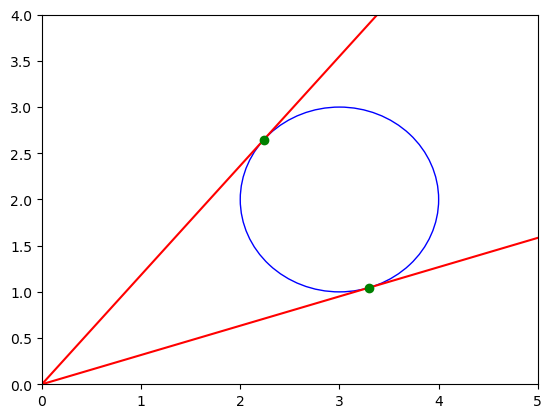

In [24]:
fig2 = plt.figure()
(xp1, yp1, s1) = coordinates_and_slopes(sol1)
(xp2, yp2, s2) = coordinates_and_slopes(sol2)
axs = fig2.gca()
center = (3, 2)
radius = 1
circle = plt.Circle(center, radius, edgecolor='blue', facecolor='none')
axs.add_artist(circle)
y1 = 5*s1 # first tangent line
y2 = 5*s2 # second tangent line
plt.plot([0, 5], [0, y1], 'r') 
plt.plot([0, 5], [0, y2], 'r') 
plt.plot([xp1, xp2], [yp1, yp2], 'go')
plt.axis([0, 5, 0, 4])
fig2.canvas.draw()
plt.savefig('touchcirclefig2')